# HW4: Multi-layer Perceptrons (MLPs)

The objective of this homework is to repeat the calculations done by [Belle et al. in 2021](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00518-y) for the prediction of the bandgap of a material.

Dataset used in this HW was provided by the author. The `.csv` file was then transformed into `.feather` file to reduce the file size. Both the `.csv` and `.feather` files are avaliable on Canvas. You may open the `.csv` file using Excel after downloading it to local. 

# Load libraries and dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from IPython.display import display

Please upload the dataset file downloaded from the Canvas to your Google Drive. Below, we provide the code for you to mount to your Google Drive to access your Drive from Colab notebook.

In [4]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After uploading the dataset file to your Google Drive and mounting to your Drive, you could load the dataset file by using `pd.read_feather(file_path)` (here, we suggest using the `.feather` file since it is much smaller than the original `.csv` file which saves your memory and is loaded much faster). Make sure the `file_path` is the correct one in your Drive (it should most likely start with `"/content/drive/MyDrive/..."`). 

In [6]:
### Write your code here ###
filepath = '/content/drive/MyDrive/576hw4/belle_data.feather'
df = pd.read_feather(filepath)
df.head()

,Species,Compound,H,He,Li,Be,B,C,N,O,...,TotalNumberOfSOrbitals,TotalNumberOfPOrbitals,TotalNumberOfDOrbitals,TotalNumberOfFOrbitals,TotalNumberOfElectrons,TotalNumberOfSElectrons,TotalNumberOfPElectrons,TotalNumberOfDElectrons,TotalNumberOfFElectrons,ValenceElectrons
0,Ac,Ac1,0,0,0,0,0,0,0,0,...,7,15,20,7,89,14,30,31,14,3
1,Ac,Ac1,0,0,0,0,0,0,0,0,...,7,15,20,7,89,14,30,31,14,3
2,Ac,Ac1,0,0,0,0,0,0,0,0,...,7,15,20,7,89,14,30,31,14,3
3,Ac,Ac1,0,0,0,0,0,0,0,0,...,7,15,20,7,89,14,30,31,14,3
4,Ac,Ac1,0,0,0,0,0,0,0,0,...,7,15,20,7,89,14,30,31,14,3


In [16]:
print(df.columns.values.tolist())

['Species', 'Compound', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og', 'DftTypeName', 'BandGap', 'Density', 'Energy', 'EnergyPerAtom', 'FermiEnergy', 'GT_HalfMetal', 'GT_InsulatorDirect', 'GT_InsulatorDirectSpinPolarised', 'GT_InsulatorIndirect', 'GT_InsulatorIndirectSpinPolarised', 'GT_Metal', 'GeometryA', 'GeometryB', 'GeometryC', 'GeometryAlpha', '

# 1. Model 1: Single feature (stoichiometry) used to predict the band gap

## One-Hot Encoding in Machine Learning

One-hot encoding is a technique widely used in machine learning for handling categorical data. In many datasets, some features are not continuous numerical values but rather categories or labels, such as colors or animal species. To enable machine learning algorithms to process and understand these categorical features, we need to convert them into numerical representations. One-hot encoding is one such method.

### When to Use One-Hot Encoding

One-hot encoding is applicable when:

1. You have categorical data in your dataset.
2. The categorical data has a limited number of unique values (i.e., low cardinality).
3. The categories have no inherent order or ranking (i.e., nominal data).

### How to Use One-Hot Encoding

To apply one-hot encoding:

1. Identify the **categorical features** in your dataset.
2. For **each unique value** in the categorical feature, create a new **binary (0 or 1) feature**.
3. Replace the original categorical feature with the new binary features. For each data point, set the binary feature corresponding to its category to 1 and all other binary features to 0.

### Example

Imagine a dataset containing a color feature with three unique values: Red, Green, and Blue. Applying one-hot encoding, we create three new binary features: `is_red`, `is_green`, and `is_blue`. The original color feature is replaced as follows:

| Color | is_red | is_green | is_blue |
|-------|--------|----------|---------|
| Red   | 1      | 0        | 0       |
| Green | 0      | 1        | 0       |
| Blue  | 0      | 0        | 1       |

### Important Note

- Some machine learning algorithms, such as decision trees and random forests, can handle categorical data without one-hot encoding. Always research the algorithm requirements before applying one-hot encoding.

### Sources that might be useful
* https://en.wikipedia.org/wiki/One-hot
* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
* https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding

Now, back to our dataset, the stoichiometry $S$ value is split into its constituent parts. This process is a form of one-hot encoding.

$S(x_{H}, x_{He}, ..., x_{Og}) \rightarrow \{H=x_{H}, He=x_{He}, ..., Og=x_{Og}\}$

To encode $H_2O$:

$S(H_2O) \rightarrow \ S(H=2, O=1) \rightarrow \{H=2, O=1, ..., Og=0\}$

Isomers have the same stoichiometric $S$ value, yet have differing physical structures ($C_{3}H_{4}$ for example). These isomers will produce identical encoding.

## 1.1. Preprocessing of the single feature dataset

In [7]:
### Write your code here ###
df_1 = df[df['BandGap']<=8]
S_df =  df_1.iloc[:,2:120]
S_df.describe()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Mt,Ds,Rg,Cn,Nh,Fl,Mc,Lv,Ts,Og
count,250318.000000,250318.0,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.0,...,250318.0,250318.0,250318.0,250318.0,250318.0,250318.0,250318.0,250318.0,250318.0,250318.0
mean,0.190785,0.0,0.101906,0.067159,0.127801,0.064850,0.089242,1.106017,0.136127,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.112007,0.0,0.936503,0.495960,1.009035,0.914966,1.077526,4.763304,1.483672,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,80.000000,0.0,88.000000,68.000000,105.000000,120.000000,64.000000,96.000000,56.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
x = S_df.values
y = df_1['BandGap'].values
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=24) # seed is fixed


In [19]:
x_train_ts = torch.from_numpy(x_train.astype(np.float32))
y_train_ts = torch.from_numpy(y_train.astype(np.float32))
x_test_ts = torch.from_numpy(x_test.astype(np.float32))
y_test_ts = torch.from_numpy(y_test.astype(np.float32))

# Apply DataLoader
train_data = Data.TensorDataset(x_train_ts, y_train_ts)
test_data = Data.TensorDataset(x_test_ts, y_test_ts)
train_loader = Data.DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=512, shuffle=True)

## 1.2. One-hidden-layer MLP

In [20]:
### Write your code here ###
hidden_size = 50
num_epoch = 300

In [21]:
# Build the MLP for regression
class MLPregression_1(nn.Module):
  def __init__(self, num_input, num_output):
    # Call the parent class constructor
    super(MLPregression_1, self).__init__()
    
    # First hidden layer
    # Linear layer with input size 'num_input' and output size 'hidden_size'
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size, bias=True)
    
    # Prediction layer
    # Linear layer with input size 'hidden_size' and output size 'num_output'
    self.predict = nn.Linear(hidden_size, num_output)

  # Define the forward pass of the model
  def forward(self, x):
    # Pass the input through the first hidden layer with ReLU activation
    x = F.relu(self.hidden1(x))
    
    # Pass the result through the prediction layer
    output = torch.squeeze(self.predict(x))
    
    # Return the final output
    return output

In [22]:
mlpreg_1 = MLPregression_1(x_train_ts.shape[1], 1)
print(mlpreg_1)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_1.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []

# Set processing bar
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_1(
  (hidden1): Linear(in_features=118, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


100%|██████████| 300/300 [11:01<00:00,  2.21s/it, Train loss=0.127, Test loss=0.159]


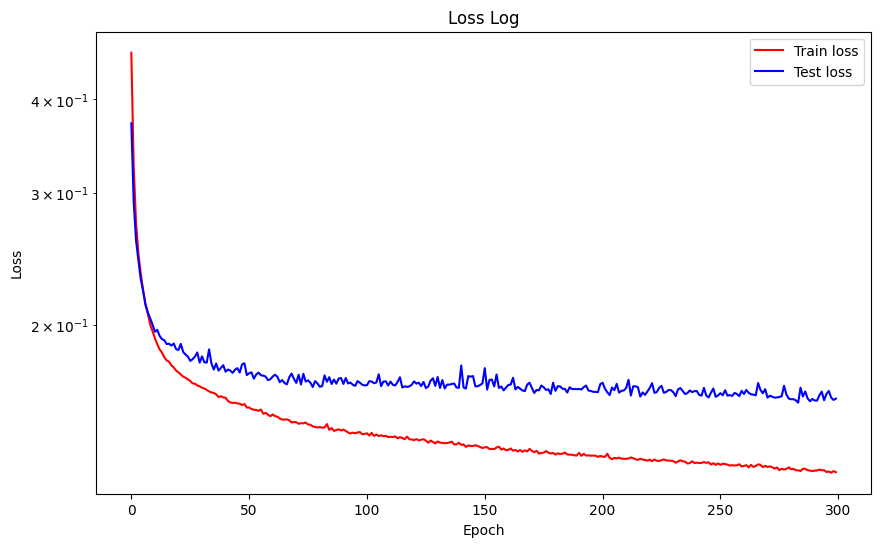

In [23]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [24]:
# Make prediction
y_pred = mlpreg_1(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp1_mae_1 = mean_absolute_error(y_test, y_pred)
mlp1_L2_1 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
mlp1_r2_1 = r2_score(y_test, y_pred)
print("R2:",mlp1_r2_1)
print("MLP_MAE:", mlp1_mae_1)
print("Relative L2 norm error for MLP with one hidden layer:", mlp1_L2_1)

R2: 0.8373215437669028
MLP_MAE: 0.15768847538759673
Relative L2 norm error for MLP with one hidden layer: 0.3861189140111472


Lower bound is -0.7963434918895544 and upper bound is 0.8002498661916111


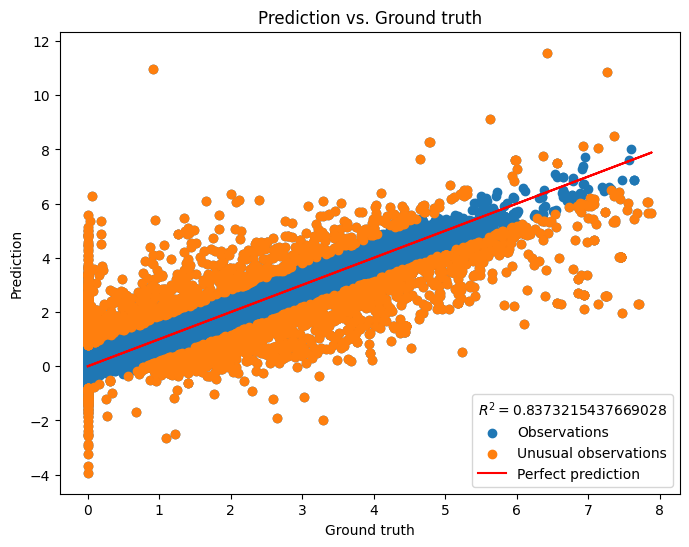

In [25]:
residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp1_r2_1))
plt.title('Prediction vs. Ground truth')
plt.show()


## 1.3. Two-hidden-layer MLP

In [26]:
hidden_size1 = 50
hidden_size2 = 25

In [27]:
### Write your code here ###
# Build the MLP for regression
class MLPregression_2(nn.Module):
  def __init__(self, num_input, num_output):
    super(MLPregression_2, self).__init__()
    
    # First hidden layer
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size1, bias=True)
    
    # Second hidden layer
    self.hidden2 = nn.Linear(hidden_size1, hidden_size2) 
    
    # Prediction layer
    self.predict = nn.Linear(hidden_size2, num_output)

  def forward(self, x):
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    output = torch.squeeze(self.predict(x))
    return output

In [28]:
mlpreg_2 = MLPregression_2(x_train_ts.shape[1], 1)
print(mlpreg_2)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_2.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []
# num_epoch = 5000
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_2(
  (hidden1): Linear(in_features=118, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=25, bias=True)
  (predict): Linear(in_features=25, out_features=1, bias=True)
)


100%|██████████| 300/300 [11:56<00:00,  2.39s/it, Train loss=0.0594, Test loss=0.106]


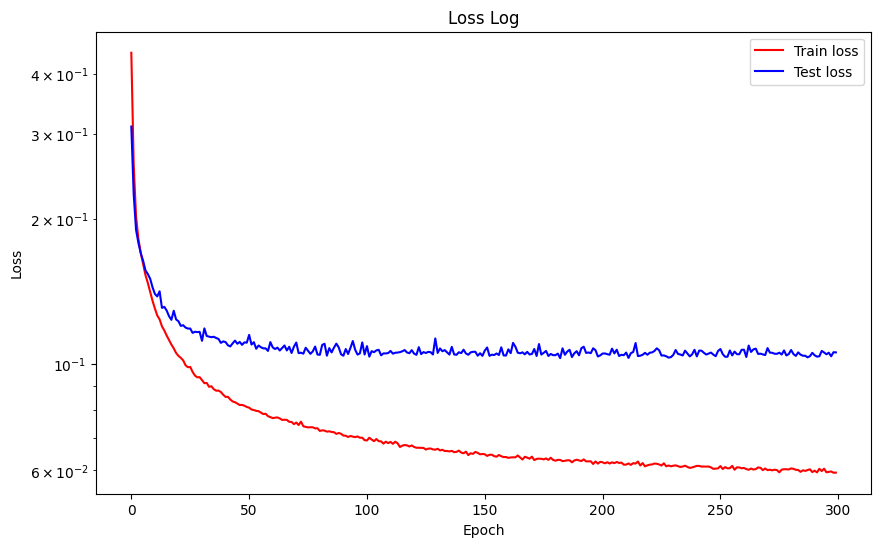

In [29]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8922530944999276
MLP_MAE: 0.101059274539922
Relative L2 norm error for MLP with two hidden layers: 0.31423782332947636
Lower bound is -0.649270598716228 and upper bound is 0.6501104750996015


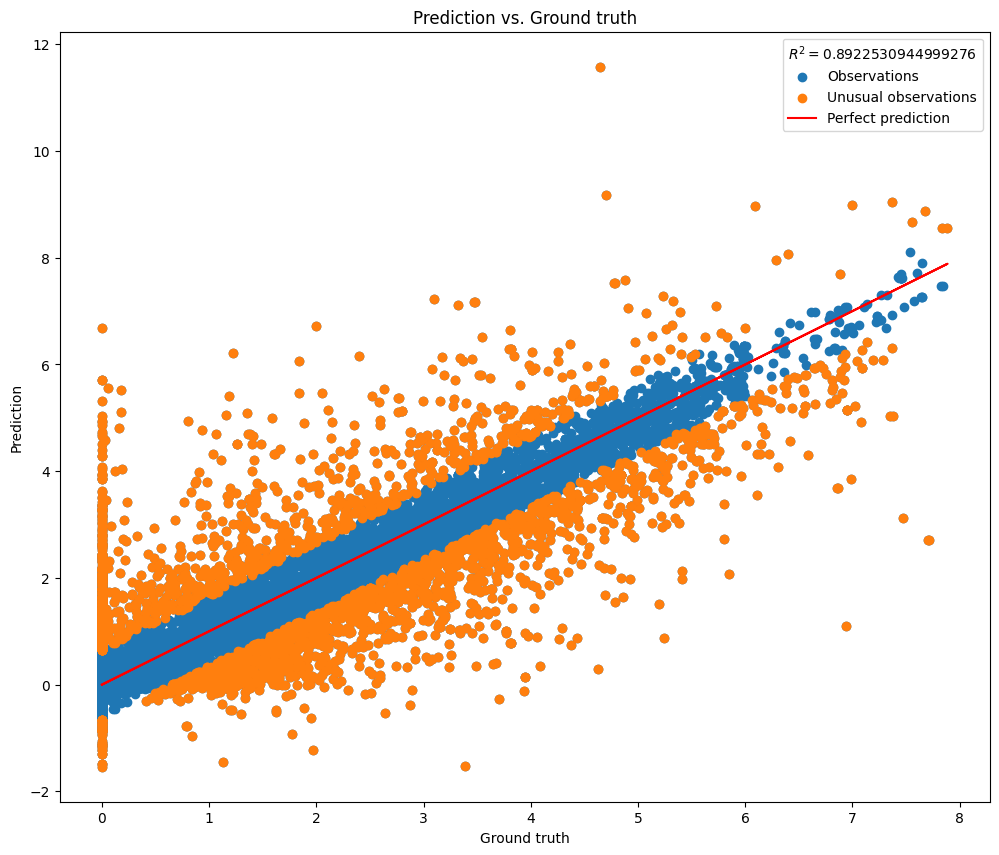

In [30]:
# Make prediction
y_pred = mlpreg_2(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp2_mae_1 = mean_absolute_error(y_test, y_pred)
mlp2_L2_1 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
# R2 value
mlp2_r2_1 = r2_score(y_test, y_pred)
print("R2:", mlp2_r2_1)
print("MLP_MAE:", mlp2_mae_1)
print("Relative L2 norm error for MLP with two hidden layers:", mlp2_L2_1)
residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp2_r2_1))
plt.title('Prediction vs. Ground truth')
plt.show()

# Model 2: Minimal features (stoichiometry, geometry, and space group) used to predict the band gap

## 2.1. Preprocessing of the minimal feature dataset

In addition to the stoichiometry $S$, space group ($SG$) is another categorical feature in the dataset. $SG$ defines one of the possible 230 symmetry groups of the crystal lattice. Therefore, we need to transform the categorical scalar into binary features. The $SG$ will then be one-hot encoded into 230 binary features. 

In [31]:
### Write your code here ###
G_df = df[['GeometryA','GeometryB','GeometryC','GeometryAlpha','GeometryBeta','GeometryGamma']]
G_df = G_df[df['BandGap']<=8]
G_df

,GeometryA,GeometryB,GeometryC,GeometryAlpha,GeometryBeta,GeometryGamma
0,4.004560,4.004560,4.004560,60.00000,60.00000,60.0000
1,4.004459,4.004459,4.004459,60.00000,60.00000,60.0000
2,3.985403,3.985403,3.985403,60.00000,60.00000,60.0000
3,3.906050,3.906050,3.906050,109.47120,109.47120,109.4712
4,3.902519,3.902519,3.902519,109.47120,109.47120,109.4712
...,...,...,...,...,...,...
250398,4.178630,4.178630,4.178630,97.83592,97.83592,136.6628
250399,4.327908,4.327908,4.327908,60.00000,60.00000,60.0000
250400,4.471183,4.471183,4.471183,60.00000,60.00000,60.0000
250401,3.204338,3.204338,7.837941,90.00000,90.00000,120.0000


In [32]:
G_df.describe()

,GeometryA,GeometryB,GeometryC,GeometryAlpha,GeometryBeta,GeometryGamma
count,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000
mean,5.109434,5.174600,5.510989,67.695379,67.788908,68.196339
std,1.451118,1.472467,2.420236,16.469098,16.356056,18.734824
min,1.317298,1.710078,1.773976,6.359576,6.359554,6.359554
25%,4.380752,4.398224,4.406056,60.000000,60.000000,60.000000
50%,4.719465,4.743964,4.759301,60.000000,60.000000,60.000000
75%,5.248533,5.304856,5.361895,60.000000,60.000000,60.000000
max,27.892470,27.892470,88.537750,169.150600,169.150600,170.138900


In [33]:
SG_df = df_1.iloc[:,140:360]
SG_df = SG_df.astype(int)
SG_df.describe()

,SG_1,SG_2,SG_3,SG_4,SG_5,SG_6,SG_7,SG_8,SG_9,SG_10,...,SG_220,SG_221,SG_222,SG_223,SG_224,SG_225,SG_226,SG_227,SG_229,SG_230
count,250318.000000,250318.000000,250318.00000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,...,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000
mean,0.000675,0.006512,0.00004,0.001310,0.000695,0.000120,0.000168,0.000467,0.001087,0.000220,...,0.000739,0.029762,0.000004,0.001634,0.000188,0.257309,0.000148,0.008166,0.002229,0.001482
std,0.025975,0.080432,0.00632,0.036175,0.026356,0.010947,0.012952,0.021615,0.032946,0.014821,...,0.027176,0.169931,0.001999,0.040389,0.013701,0.437152,0.012157,0.089994,0.047161,0.038470
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
minimal_df = pd.concat([S_df, G_df, SG_df],axis=1)

minimal_df.describe()

,H,He,Li,Be,B,C,N,O,F,Ne,...,SG_220,SG_221,SG_222,SG_223,SG_224,SG_225,SG_226,SG_227,SG_229,SG_230
count,250318.000000,250318.0,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.0,...,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000,250318.000000
mean,0.190785,0.0,0.101906,0.067159,0.127801,0.064850,0.089242,1.106017,0.136127,0.0,...,0.000739,0.029762,0.000004,0.001634,0.000188,0.257309,0.000148,0.008166,0.002229,0.001482
std,2.112007,0.0,0.936503,0.495960,1.009035,0.914966,1.077526,4.763304,1.483672,0.0,...,0.027176,0.169931,0.001999,0.040389,0.013701,0.437152,0.012157,0.089994,0.047161,0.038470
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,80.000000,0.0,88.000000,68.000000,105.000000,120.000000,64.000000,96.000000,56.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
x = minimal_df.values
y = df_1['BandGap'].values
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=24) # seed is fixed
print('dimention of x_train:', x_train.shape)
print('dimention of x_test:', x_test.shape)

dimention of x_train: (175222, 344)
dimention of x_test: (75096, 344)


In [36]:
x_train_ts = torch.from_numpy(x_train.astype(np.float32))
y_train_ts = torch.from_numpy(y_train.astype(np.float32))
x_test_ts = torch.from_numpy(x_test.astype(np.float32))
y_test_ts = torch.from_numpy(y_test.astype(np.float32))

# Apply DataLoader
train_data = Data.TensorDataset(x_train_ts, y_train_ts)
test_data = Data.TensorDataset(x_test_ts, y_test_ts)
train_loader = Data.DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=512, shuffle=True)

## 2.2. One-hidden-layer MLP

In [37]:
### Write your code here ###
hidden_size = 50
num_epoch = 300

In [38]:
# Build the MLP for regression
class MLPregression_1(nn.Module):
  def __init__(self, num_input, num_output):
    # Call the parent class constructor
    super(MLPregression_1, self).__init__()
    
    # First hidden layer
    # Linear layer with input size 'num_input' and output size 'hidden_size'
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size, bias=True)
    
    # Prediction layer
    # Linear layer with input size 'hidden_size' and output size 'num_output'
    self.predict = nn.Linear(hidden_size, num_output)

  # Define the forward pass of the model
  def forward(self, x):
    # Pass the input through the first hidden layer with ReLU activation
    x = F.relu(self.hidden1(x))
    
    # Pass the result through the prediction layer
    output = torch.squeeze(self.predict(x))
    
    # Return the final output
    return output

In [39]:
mlpreg_1 = MLPregression_1(x_train_ts.shape[1], 1)
print(mlpreg_1)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_1.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []

# Set processing bar
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_1(
  (hidden1): Linear(in_features=344, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


100%|██████████| 300/300 [12:55<00:00,  2.58s/it, Train loss=0.0901, Test loss=0.14]


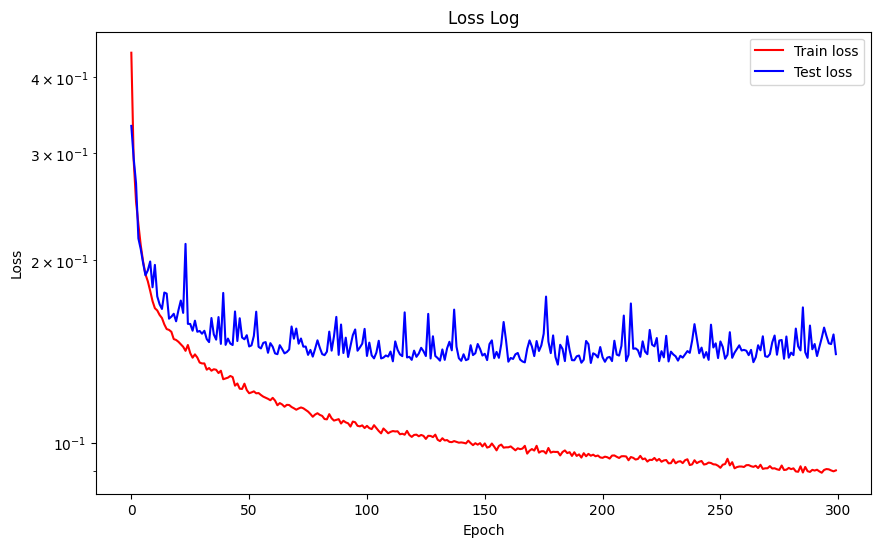

In [40]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8570511272115295
MLP_MAE: 0.13346700620380653
Relative L2 norm error for MLP with one hidden layer: 0.36194820098965613
Lower bound is -0.7452618259862849 and upper bound is 0.751354470390627


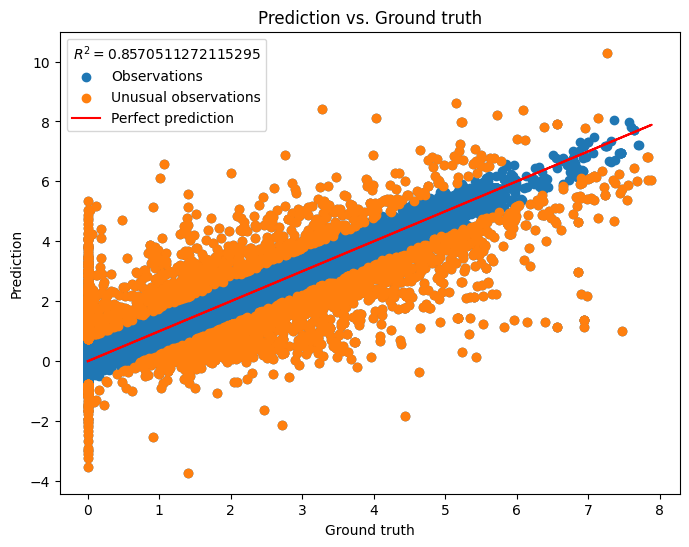

In [41]:
# Make prediction
y_pred = mlpreg_1(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp1_mae_2 = mean_absolute_error(y_test, y_pred)
mlp1_L2_2 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
mlp1_r2_2 = r2_score(y_test, y_pred)
print("R2:",mlp1_r2_2)
print("MLP_MAE:", mlp1_mae_2)
print("Relative L2 norm error for MLP with one hidden layer:", mlp1_L2_2)

residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp1_r2_2))
plt.title('Prediction vs. Ground truth')
plt.show()

## 2.3. Two-hidden-layer MLP

In [71]:
### Write your code here ###
hidden_size1 = 50
hidden_size2 = 25

In [72]:
# Build the MLP for regression
class MLPregression_2(nn.Module):
  def __init__(self, num_input, num_output):
    super(MLPregression_2, self).__init__()
    
    # First hidden layer
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size1, bias=True)
    
    # Second hidden layer
    self.hidden2 = nn.Linear(hidden_size1, hidden_size2) 
    
    # Prediction layer
    self.predict = nn.Linear(hidden_size2, num_output)

  def forward(self, x):
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    output = torch.squeeze(self.predict(x))
    return output

In [44]:
mlpreg_2 = MLPregression_2(x_train_ts.shape[1], 1)
print(mlpreg_2)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_2.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []
# num_epoch = 5000
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_2(
  (hidden1): Linear(in_features=344, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=25, bias=True)
  (predict): Linear(in_features=25, out_features=1, bias=True)
)


100%|██████████| 300/300 [13:48<00:00,  2.76s/it, Train loss=0.0532, Test loss=0.11]


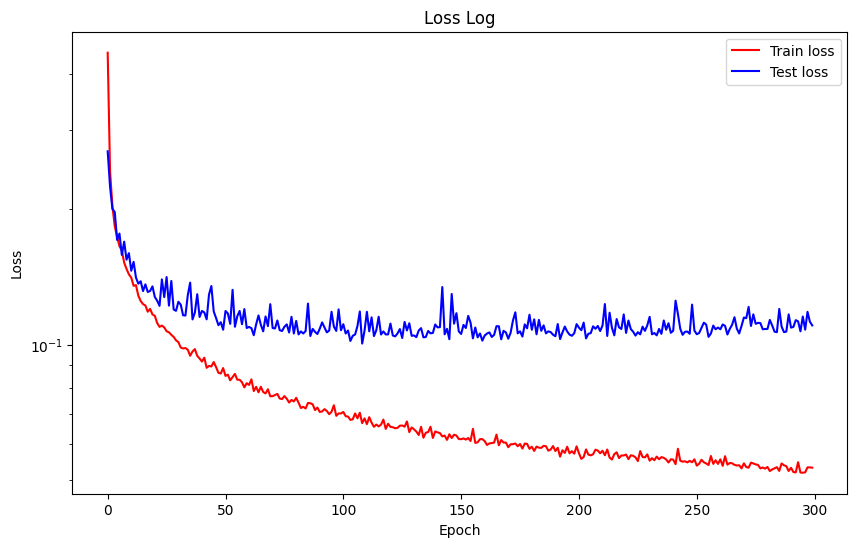

In [45]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8873601628911557
MLP_MAE: 0.09830439103306596
Relative L2 norm error for MLP with two hidden layers: 0.3212935903631934
Lower bound is -0.6706329688080475 and upper bound is 0.6576720772786095


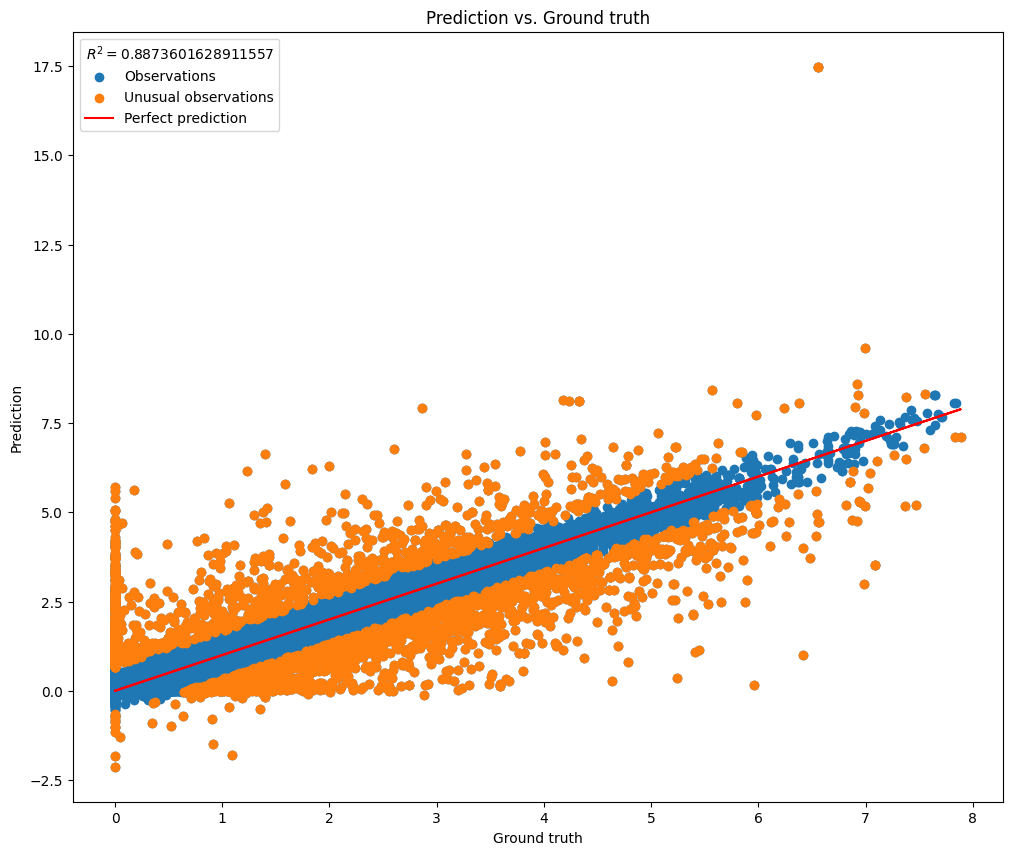

In [46]:
# Make prediction
y_pred = mlpreg_2(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp2_mae_2 = mean_absolute_error(y_test, y_pred)
mlp2_L2_2 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
# R2 value
mlp2_r2_2 = r2_score(y_test, y_pred)
print("R2:", mlp2_r2_2)
print("MLP_MAE:", mlp2_mae_2)
print("Relative L2 norm error for MLP with two hidden layers:", mlp2_L2_2)
residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp2_r2_2))
plt.title('Prediction vs. Ground truth')
plt.show()

# Model 3: Maximal features (all features except `Species`, `Compound`, `DftTypeName`, `KSpace`, `BandGap`)

## 3.1. Preprocessing of the maximal feature dataset

In [78]:
### Write your code here ###
maximal_df = df_1.drop(['Species','Compound','DftTypeName','KSpace','BandGap'],axis = 1)
print(maximal_df.shape)

(250318, 398)


In [79]:
numeric_df = maximal_df.select_dtypes(include=['float64', 'int64'])
print("Dimensions of numeric DataFrame:", numeric_df.shape)
bool_df = maximal_df.select_dtypes(include=['bool'])
print("Dimensions of Boolean DataFrame:", bool_df.shape)

Dimensions of numeric DataFrame: (250318, 146)
Dimensions of Boolean DataFrame: (250318, 252)


In [80]:
maximal_df[maximal_df.select_dtypes(include=['bool']).columns] = maximal_df.select_dtypes(include=['bool']).astype('int')
print(maximal_df.shape)
print(maximal_df.describe())

(250318, 398)
                   H        He             Li             Be              B  \
count  250318.000000  250318.0  250318.000000  250318.000000  250318.000000   
mean        0.190785       0.0       0.101906       0.067159       0.127801   
std         2.112007       0.0       0.936503       0.495960       1.009035   
min         0.000000       0.0       0.000000       0.000000       0.000000   
25%         0.000000       0.0       0.000000       0.000000       0.000000   
50%         0.000000       0.0       0.000000       0.000000       0.000000   
75%         0.000000       0.0       0.000000       0.000000       0.000000   
max        80.000000       0.0      88.000000      68.000000     105.000000   

                   C              N              O              F        Ne  \
count  250318.000000  250318.000000  250318.000000  250318.000000  250318.0   
mean        0.064850       0.089242       1.106017       0.136127       0.0   
std         0.914966       1.077526  

In [81]:
x = maximal_df.values
y = df_1['BandGap'].values
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=24) # seed is fixed
print('dimention of x_train:', x_train.shape)
print('dimention of x_test:', x_test.shape)

x_train_ts = torch.from_numpy(x_train.astype(np.float32))
y_train_ts = torch.from_numpy(y_train.astype(np.float32))
x_test_ts = torch.from_numpy(x_test.astype(np.float32))
y_test_ts = torch.from_numpy(y_test.astype(np.float32))

# Apply DataLoader
train_data = Data.TensorDataset(x_train_ts, y_train_ts)
test_data = Data.TensorDataset(x_test_ts, y_test_ts)
train_loader = Data.DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=512, shuffle=True)

dimention of x_train: (175222, 398)
dimention of x_test: (75096, 398)


## 3.2. One-hidden-layer MLP

In [51]:
### Write your code here ###
mlpreg_1 = MLPregression_1(x_train_ts.shape[1], 1)
print(mlpreg_1)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_1.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []

# Set processing bar
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_1(
  (hidden1): Linear(in_features=398, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


100%|██████████| 300/300 [16:18<00:00,  3.26s/it, Train loss=0.0595, Test loss=0.099]


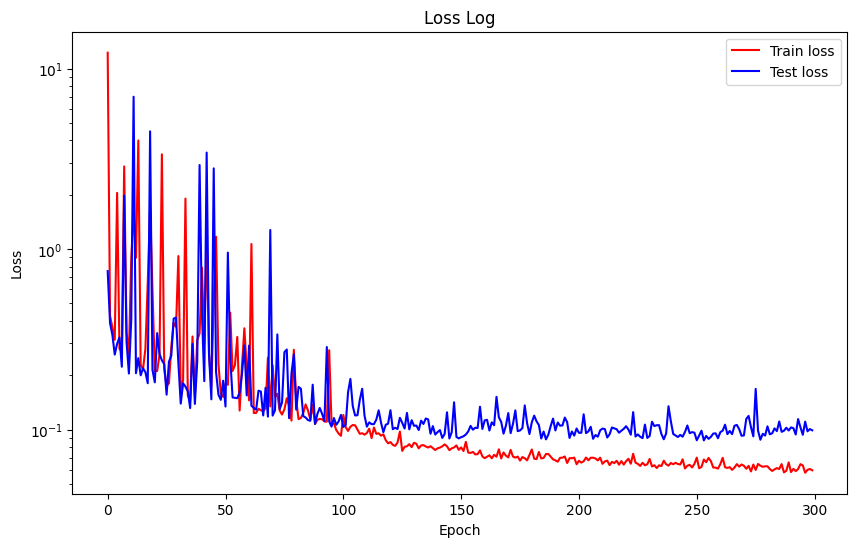

In [52]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8988810072006438
MLP_MAE: 0.06809399195312771
Relative L2 norm error for MLP with one hidden layer: 0.304419467815155
Lower bound is -0.6365737069434206 and upper bound is 0.6218655176467204


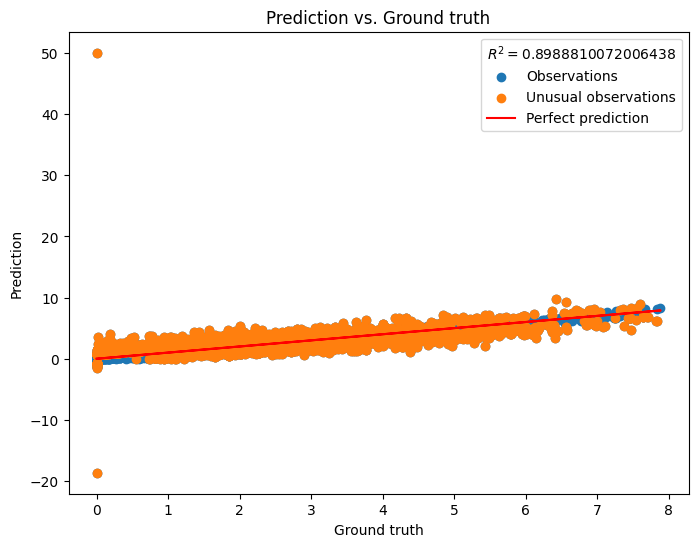

In [53]:
# Make prediction
y_pred = mlpreg_1(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp1_mae_3 = mean_absolute_error(y_test, y_pred)
mlp1_L2_3 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
mlp1_r2_3 = r2_score(y_test, y_pred)
print("R2:",mlp1_r2_3)
print("MLP_MAE:", mlp1_mae_3)
print("Relative L2 norm error for MLP with one hidden layer:", mlp1_L2_3)

residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp1_r2_3))
plt.title('Prediction vs. Ground truth')
plt.show()

## 3.3. Two-hidden-layer MLP

In [82]:
### Write your code here ###
hidden_size1 = 50
hidden_size2 = 25

In [83]:
# Build the MLP for regression
class MLPregression_2(nn.Module):
  def __init__(self, num_input, num_output):
    super(MLPregression_2, self).__init__()
    
    # First hidden layer
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size1, bias=True)
    
    # Second hidden layer
    self.hidden2 = nn.Linear(hidden_size1, hidden_size2) 
    
    # Prediction layer
    self.predict = nn.Linear(hidden_size2, num_output)

  def forward(self, x):
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    output = torch.squeeze(self.predict(x))
    return output

In [84]:
### Write your code here ###
mlpreg_2 = MLPregression_2(x_train_ts.shape[1], 1)
print(mlpreg_2)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_2.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []
# num_epoch = 5000
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_2(
  (hidden1): Linear(in_features=398, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=25, bias=True)
  (predict): Linear(in_features=25, out_features=1, bias=True)
)


100%|██████████| 300/300 [16:07<00:00,  3.22s/it, Train loss=0.0396, Test loss=0.0874]


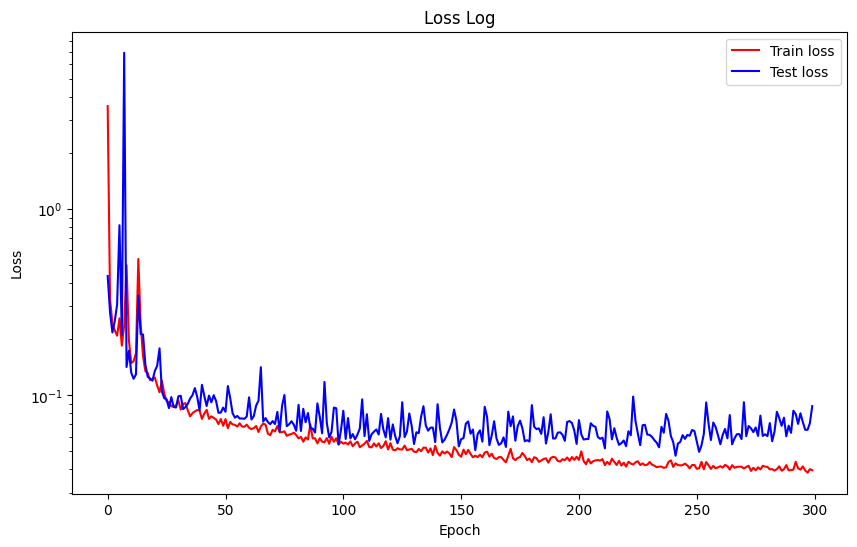

In [85]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.9107131856291915
MLP_MAE: 0.10108709007072142
Relative L2 norm error for MLP with two hidden layers: 0.28605511569873265
Lower bound is -0.551943966779921 and upper bound is 0.6224633127124787


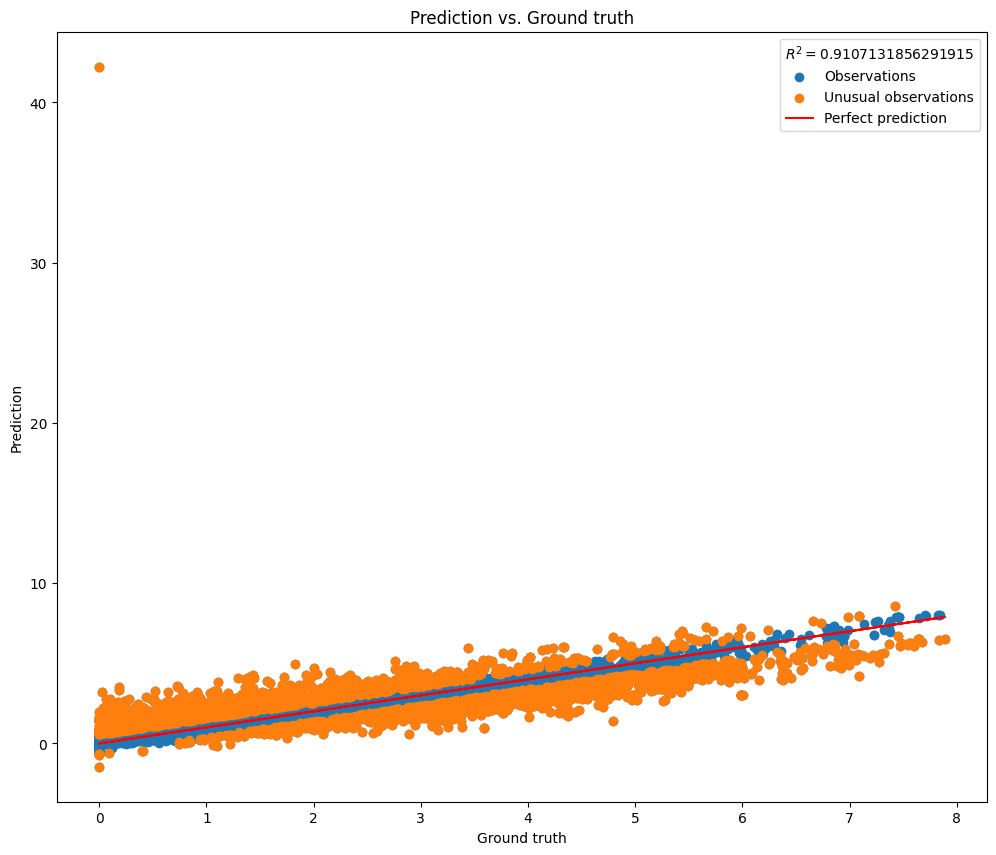

In [86]:
# Make prediction
y_pred = mlpreg_2(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp2_mae_3 = mean_absolute_error(y_test, y_pred)
mlp2_L2_3 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
# R2 value
mlp2_r2_3 = r2_score(y_test, y_pred)
print("R2:", mlp2_r2_3)
print("MLP_MAE:", mlp2_mae_3)
print("Relative L2 norm error for MLP with two hidden layers:", mlp2_L2_3)
residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp2_r2_3))
plt.title('Prediction vs. Ground truth')
plt.show()

# 4. Comparison of results

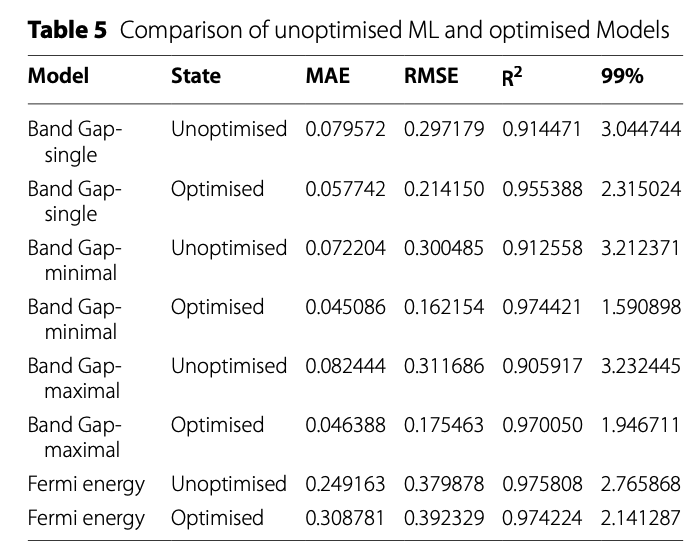

In [90]:
### Write your code here ###
d = {'model' :['Band Gap-single One Layer', 'Band Gap-single Two Layers', 'Band Gap-minimal One Layer','Band Gap-minimal Two Layers','Band Gap-maximal One Layer','Band Gap-maximal Two Layers'],
'State':['Unoptimised', 'Unoptimised', 'Unoptimised','Unoptimised', 'Unoptimised', 'Unoptimised'],
'MAE':[mlp1_mae_1,mlp2_mae_1,mlp1_mae_2,mlp2_mae_2,mlp1_mae_3,mlp2_mae_3],
'L2':[mlp1_L2_1,mlp2_L2_1,mlp1_L2_2,mlp2_L2_2,mlp1_L2_3,mlp2_L2_3],
'R2':[mlp1_r2_1,mlp2_r2_1,mlp1_r2_2,mlp2_r2_2,mlp1_r2_3,mlp2_r2_3]}
d = pd.DataFrame(d)
print(d)

                         model        State       MAE        L2        R2
0    Band Gap-single One Layer  Unoptimised  0.157688  0.386119  0.837322
1   Band Gap-single Two Layers  Unoptimised  0.101059  0.314238  0.892253
2   Band Gap-minimal One Layer  Unoptimised  0.133467  0.361948  0.857051
3  Band Gap-minimal Two Layers  Unoptimised  0.098304  0.321294  0.887360
4   Band Gap-maximal One Layer  Unoptimised  0.068094  0.304419  0.898881
5  Band Gap-maximal Two Layers  Unoptimised  0.101087  0.286055  0.910713


In the paper, the author trained three types of models using two hidden layer MLP models to predict the bandgap. As shown in the figure above, optimised models always gives better accuracy than unoptimised ones. And for the three input types of unoptimised models, the models wtih single input dataset and minimal dataset performed nearly the same and a little bit higher than the maximal dataset's accuracy, an assumption is that too many input features increase overfitting compared to the other two models. For optimised ones,  the model with minimal input dataset gives the best prediction. In this homework, the overall performance of the models are worse than that in the paper, which is resonable. Our simplified model has less epochs and less features. In this homework, two layer MLP always performed better than one layer models, and the best model is two hidden layer MLP with maximal dataset input. In the on layer models, the best one is single input dataset, and the worst one is the maximal input dataset. For MAE metrics, that obtained in the paper is better than that obtained in this homework for single input dataset and minimal input dataset.

# 5. Reproduce the maximal features test results reported in the paper

## 5.1. Preprocessing of the new maximal feature dataset (follows the output log)

Follows the output log provided by the author: https://github.com/carlyman77/MaterialsDiscoveryML/blob/master/Models/BandGap_SpaceGroup-HighSymmetry-Derived_T/Output.log

2021-05-02 14:48:55,925 INFO Remaining columns to use:

2021-05-02 14:48:55,925 INFO ['Compound', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ac', 'Th', 'Pa', 'U', 'Pu', 'BandGap', 'SG_1', 'SG_2', 'SG_3', 'SG_4', 'SG_5', 'SG_6', 'SG_7', 'SG_8', 'SG_9', 'SG_10', 'SG_11', 'SG_12', 'SG_13', 'SG_14', 'SG_15', 'SG_16', 'SG_17', 'SG_18', 'SG_19', 'SG_20', 'SG_21', 'SG_22', 'SG_23', 'SG_24', 'SG_25', 'SG_26', 'SG_27', 'SG_28', 'SG_29', 'SG_30', 'SG_31', 'SG_32', 'SG_33', 'SG_34', 'SG_35', 'SG_36', 'SG_37', 'SG_38', 'SG_39', 'SG_40', 'SG_41', 'SG_42', 'SG_43', 'SG_44', 'SG_45', 'SG_46', 'SG_47', 'SG_48', 'SG_50', 'SG_51', 'SG_52', 'SG_53', 'SG_54', 'SG_55', 'SG_56', 'SG_57', 'SG_58', 'SG_59', 'SG_60', 'SG_61', 'SG_62', 'SG_63', 'SG_64', 'SG_65', 'SG_66', 'SG_67', 'SG_68', 'SG_69', 'SG_70', 'SG_71', 'SG_72', 'SG_73', 'SG_74', 'SG_75', 'SG_76', 'SG_77', 'SG_78', 'SG_79', 'SG_80', 'SG_81', 'SG_82', 'SG_83', 'SG_84', 'SG_85', 'SG_86', 'SG_87', 'SG_88', 'SG_90', 'SG_91', 'SG_92', 'SG_95', 'SG_96', 'SG_97', 'SG_98', 'SG_99', 'SG_100', 'SG_102', 'SG_103', 'SG_104', 'SG_105', 'SG_106', 'SG_107', 'SG_108', 'SG_109', 'SG_110', 'SG_111', 'SG_112', 'SG_113', 'SG_114', 'SG_115', 'SG_116', 'SG_117', 'SG_118', 'SG_119', 'SG_120', 'SG_121', 'SG_122', 'SG_123', 'SG_124', 'SG_125', 'SG_126', 'SG_127', 'SG_128', 'SG_129', 'SG_130', 'SG_131', 'SG_132', 'SG_133', 'SG_134', 'SG_135', 'SG_136', 'SG_137', 'SG_138', 'SG_139', 'SG_140', 'SG_141', 'SG_142', 'SG_143', 'SG_144', 'SG_145', 'SG_146', 'SG_147', 'SG_148', 'SG_149', 'SG_150', 'SG_151', 'SG_152', 'SG_153', 'SG_154', 'SG_155', 'SG_156', 'SG_157', 'SG_158', 'SG_159', 'SG_160', 'SG_161', 'SG_162', 'SG_163', 'SG_164', 'SG_165', 'SG_166', 'SG_167', 'SG_169', 'SG_170', 'SG_171', 'SG_173', 'SG_174', 'SG_175', 'SG_176', 'SG_177', 'SG_178', 'SG_179', 'SG_180', 'SG_181', 'SG_182', 'SG_183', 'SG_184', 'SG_185', 'SG_186', 'SG_187', 'SG_188', 'SG_189', 'SG_190', 'SG_191', 'SG_192', 'SG_193', 'SG_194', 'SG_195', 'SG_196', 'SG_197', 'SG_198', 'SG_199', 'SG_200', 'SG_201', 'SG_202', 'SG_203', 'SG_204', 'SG_205', 'SG_206', 'SG_208', 'SG_210', 'SG_211', 'SG_212', 'SG_213', 'SG_214', 'SG_215', 'SG_216', 'SG_217', 'SG_218', 'SG_219', 'SG_220', 'SG_221', 'SG_222', 'SG_223', 'SG_224', 'SG_225', 'SG_226', 'SG_227', 'SG_229', 'SG_230', 'HS_I', 'HS_2', 'Mirror', 'HS_21', 'Glide', 'HS_4', 'HS_4143', 'HS_42', 'HS_4Bar', 'HS_2M', 'HS_21M', 'HS_4M', 'HS_42M', 'HS_3', 'HS_31', 'HS_32', 'HS_3Bar', 'HS_6', 'HS_61', 'HS_62', 'HS_63', 'HS_64', 'HS_65', 'HS_6Bar', 'HS_6M', 'HS_63M', 'NumberOfAtoms', 'TotalAtomicWeight', 'TotalChemicalPotential', 'TotalElectronAffinity', 'TotalElectroNegativity', 'TotalIonisationEnergy', 'TotalDensity', 'TotalNumberOfSOrbitals', 'TotalNumberOfPOrbitals', 'TotalNumberOfDOrbitals', 'TotalNumberOfFOrbitals', 'TotalNumberOfElectrons', 'TotalNumberOfSElectrons', 'TotalNumberOfPElectrons', 'TotalNumberOfDElectrons', 'TotalNumberOfFElectrons', 'ValenceElectrons']


In [9]:
### Write your code here ###
new_maximal = df[['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ac', 'Th', 'Pa', 'U', 'Pu', 'SG_1', 'SG_2', 'SG_3', 'SG_4', 'SG_5', 'SG_6', 'SG_7', 'SG_8', 'SG_9', 'SG_10', 'SG_11', 'SG_12', 'SG_13', 'SG_14', 'SG_15', 'SG_16', 'SG_17', 'SG_18', 'SG_19', 'SG_20', 'SG_21', 'SG_22', 'SG_23', 'SG_24', 'SG_25', 'SG_26', 'SG_27', 'SG_28', 'SG_29', 'SG_30', 'SG_31', 'SG_32', 'SG_33', 'SG_34', 'SG_35', 'SG_36', 'SG_37', 'SG_38', 'SG_39', 'SG_40', 'SG_41', 'SG_42', 'SG_43', 'SG_44', 'SG_45', 'SG_46', 'SG_47', 'SG_48', 'SG_50', 'SG_51', 'SG_52', 'SG_53', 'SG_54', 'SG_55', 'SG_56', 'SG_57', 'SG_58', 'SG_59', 'SG_60', 'SG_61', 'SG_62', 'SG_63', 'SG_64', 'SG_65', 'SG_66', 'SG_67', 'SG_68', 'SG_69', 'SG_70', 'SG_71', 'SG_72', 'SG_73', 'SG_74', 'SG_75', 'SG_76', 'SG_77', 'SG_78', 'SG_79', 'SG_80', 'SG_81', 'SG_82', 'SG_83', 'SG_84', 'SG_85', 'SG_86', 'SG_87', 'SG_88', 'SG_90', 'SG_91', 'SG_92', 'SG_95', 'SG_96', 'SG_97', 'SG_98', 'SG_99', 'SG_100', 'SG_102', 'SG_103', 'SG_104', 'SG_105', 'SG_106', 'SG_107', 'SG_108', 'SG_109', 'SG_110', 'SG_111', 'SG_112', 'SG_113', 'SG_114', 'SG_115', 'SG_116', 'SG_117', 'SG_118', 'SG_119', 'SG_120', 'SG_121', 'SG_122', 'SG_123', 'SG_124', 'SG_125', 'SG_126', 'SG_127', 'SG_128', 'SG_129', 'SG_130', 'SG_131', 'SG_132', 'SG_133', 'SG_134', 'SG_135', 'SG_136', 'SG_137', 'SG_138', 'SG_139', 'SG_140', 'SG_141', 'SG_142', 'SG_143', 'SG_144', 'SG_145', 'SG_146', 'SG_147', 'SG_148', 'SG_149', 'SG_150', 'SG_151', 'SG_152', 'SG_153', 'SG_154', 'SG_155', 'SG_156', 'SG_157', 'SG_158', 'SG_159', 'SG_160', 'SG_161', 'SG_162', 'SG_163', 'SG_164', 'SG_165', 'SG_166', 'SG_167', 'SG_169', 'SG_170', 'SG_171', 'SG_173', 'SG_174', 'SG_175', 'SG_176', 'SG_177', 'SG_178', 'SG_179', 'SG_180', 'SG_181', 'SG_182', 'SG_183', 'SG_184', 'SG_185', 'SG_186', 'SG_187', 'SG_188', 'SG_189', 'SG_190', 'SG_191', 'SG_192', 'SG_193', 'SG_194', 'SG_195', 'SG_196', 'SG_197', 'SG_198', 'SG_199', 'SG_200', 'SG_201', 'SG_202', 'SG_203', 'SG_204', 'SG_205', 'SG_206', 'SG_208', 'SG_210', 'SG_211', 'SG_212', 'SG_213', 'SG_214', 'SG_215', 'SG_216', 'SG_217', 'SG_218', 'SG_219', 'SG_220', 'SG_221', 'SG_222', 'SG_223', 'SG_224', 'SG_225', 'SG_226', 'SG_227', 'SG_229', 'SG_230', 'HS_I', 'HS_2', 'Mirror', 'HS_21', 'Glide', 'HS_4', 'HS_4143', 'HS_42', 'HS_4Bar', 'HS_2M', 'HS_21M', 'HS_4M', 'HS_42M', 'HS_3', 'HS_31', 'HS_32', 'HS_3Bar', 'HS_6', 'HS_61', 'HS_62', 'HS_63', 'HS_64', 'HS_65', 'HS_6Bar', 'HS_6M', 'HS_63M', 'NumberOfAtoms', 'TotalAtomicWeight', 'TotalChemicalPotential', 'TotalElectronAffinity', 'TotalElectroNegativity', 'TotalIonisationEnergy', 'TotalDensity', 'TotalNumberOfSOrbitals', 'TotalNumberOfPOrbitals', 'TotalNumberOfDOrbitals', 'TotalNumberOfFOrbitals', 'TotalNumberOfElectrons', 'TotalNumberOfSElectrons', 'TotalNumberOfPElectrons', 'TotalNumberOfDElectrons', 'TotalNumberOfFElectrons', 'ValenceElectrons']]
new_maximal[new_maximal.select_dtypes(include=['bool']).columns] = new_maximal.select_dtypes(include=['bool']).astype('int')
print(new_maximal.shape)
print(new_maximal.describe())

<ipython-input-9-a84a51f95d8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_maximal[new_maximal.select_dtypes(include=['bool']).columns] = new_maximal.select_dtypes(include=['bool']).astype('int')


(250403, 351)
                   H             He             Li             Be  \
count  250403.000000  250403.000000  250403.000000  250403.000000   
mean        0.190741       0.000112       0.101888       0.067272   
std         2.111666       0.015479       0.936365       0.496720   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max        80.000000       4.000000      88.000000      68.000000   

                   B              C              N              O  \
count  250403.000000  250403.000000  250403.000000  250403.000000   
mean        0.127834       0.064859       0.089212       1.105670   
std         1.009128       0.914845       1.077344       4.762535   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.00000

In [10]:
x = new_maximal.values
y = df['BandGap'].values
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=24) # seed is fixed
print('dimention of x_train:', x_train.shape)
print('dimention of x_test:', x_test.shape)

x_train_ts = torch.from_numpy(x_train.astype(np.float32))
y_train_ts = torch.from_numpy(y_train.astype(np.float32))
x_test_ts = torch.from_numpy(x_test.astype(np.float32))
y_test_ts = torch.from_numpy(y_test.astype(np.float32))

# Apply DataLoader
train_data = Data.TensorDataset(x_train_ts, y_train_ts)
test_data = Data.TensorDataset(x_test_ts, y_test_ts)
train_loader = Data.DataLoader(dataset=train_data, batch_size=200, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=200, shuffle=True)

dimention of x_train: (175282, 351)
dimention of x_test: (75121, 351)


## 5.2. MLPs

In [11]:
### Write your code here ###
### Write your code here ###
hidden_size = 50
num_epoch = 300
# Build the MLP for regression
class MLPregression_1(nn.Module):
  def __init__(self, num_input, num_output):
    # Call the parent class constructor
    super(MLPregression_1, self).__init__()
    
    # First hidden layer
    # Linear layer with input size 'num_input' and output size 'hidden_size'
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size, bias=True)
    
    # Prediction layer
    # Linear layer with input size 'hidden_size' and output size 'num_output'
    self.predict = nn.Linear(hidden_size, num_output)

  # Define the forward pass of the model
  def forward(self, x):
    # Pass the input through the first hidden layer with ReLU activation
    x = F.relu(self.hidden1(x))
    
    # Pass the result through the prediction layer
    output = torch.squeeze(self.predict(x))
    
    # Return the final output
    return output

In [12]:
mlpreg_1 = MLPregression_1(x_train_ts.shape[1], 1)
print(mlpreg_1)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_1.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []

# Set processing bar
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_1(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_1(
  (hidden1): Linear(in_features=351, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


  2%|▏         | 7/300 [00:26<18:13,  3.73s/it, Train loss=0.438, Test loss=0.673]


KeyboardInterrupt: ignored

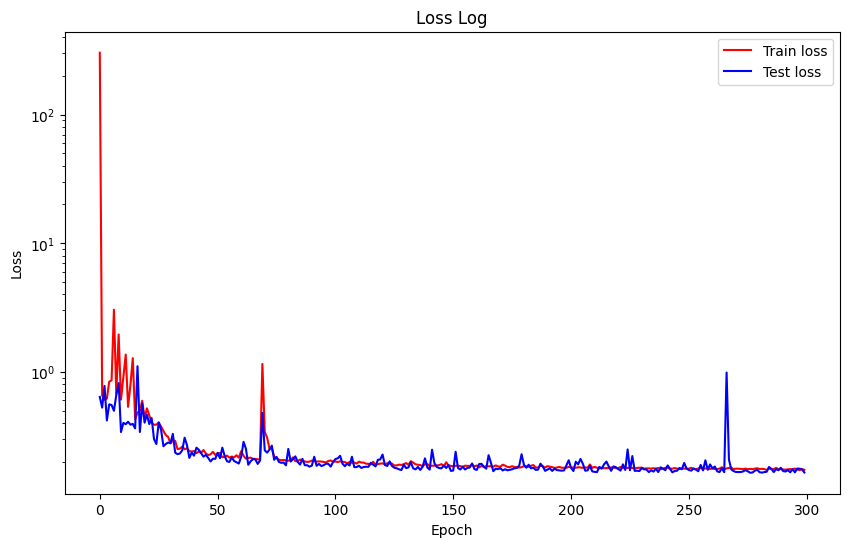

In [63]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8347469454125485
MLP_MAE: 0.1536363782682386
Relative L2 norm error for MLP with one hidden layer: 0.3896537089125605
Lower bound is -0.805073903508649 and upper bound is 0.8198547228470553


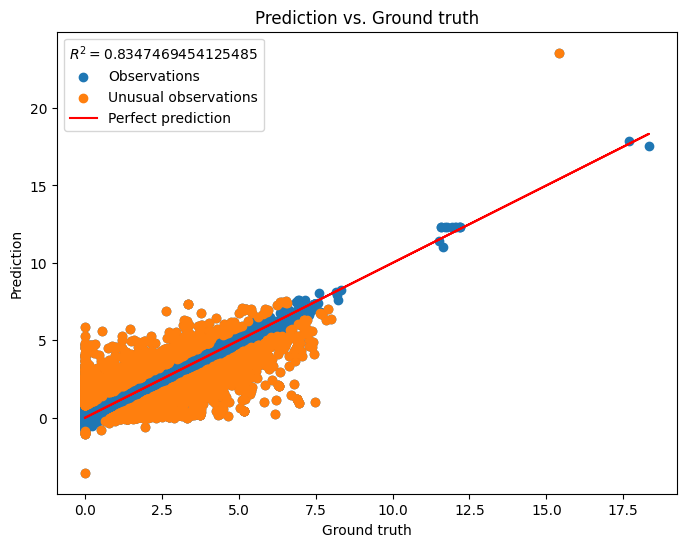

In [64]:
# Make prediction
y_pred = mlpreg_1(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp1_mae_5 = mean_absolute_error(y_test, y_pred)
mlp1_L2_5 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
mlp1_r2_5 = r2_score(y_test, y_pred)
print("R2:",mlp1_r2_5)
print("MLP_MAE:", mlp1_mae_5)
print("Relative L2 norm error for MLP with one hidden layer:", mlp1_L2_5)

residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp1_r2_5))
plt.title('Prediction vs. Ground truth')
plt.show()

In [13]:
### Write your code here ###
hidden_size1 = 100
hidden_size2 = 50
# Build the MLP for regression
class MLPregression_2(nn.Module):
  def __init__(self, num_input, num_output):
    super(MLPregression_2, self).__init__()
    
    # First hidden layer
    self.hidden1 = nn.Linear(in_features=num_input, out_features=hidden_size1, bias=True)
    
    # Second hidden layer
    self.hidden2 = nn.Linear(hidden_size1, hidden_size2) 
    
    # Prediction layer
    self.predict = nn.Linear(hidden_size2, num_output)

  def forward(self, x):
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    output = torch.squeeze(self.predict(x))
    return output

In [14]:
mlpreg_2 = MLPregression_2(x_train_ts.shape[1], 1)
print(mlpreg_2)

# Define optimizer
optimizer = torch.optim.Adam(mlpreg_2.parameters(), lr=1e-3)

# Define loss function
loss_func = nn.MSELoss()

# Start training
train_loss_log = []
test_loss_log = []
# num_epoch = 5000
pbar = trange(num_epoch)
for epoch in pbar:
  train_loss = 0
  test_loss = 0
  train_num = 0
  test_num = 0
  
  # Train loss
  for step, (b_x, b_y) in enumerate(train_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_log.append(train_loss/train_num)
  
  # Test loss
  for step, (b_x, b_y) in enumerate(test_loader):
    output = mlpreg_2(b_x)
    loss = loss_func(output, b_y)
    test_loss += loss.item() * b_x.size(0)
    test_num += b_x.size(0)
  test_loss_log.append(test_loss/test_num)

  pbar.set_postfix({'Train loss': train_loss_log[-1], 'Test loss': test_loss_log[-1]})

MLPregression_2(
  (hidden1): Linear(in_features=351, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


100%|██████████| 300/300 [30:53<00:00,  6.18s/it, Train loss=0.127, Test loss=0.128]


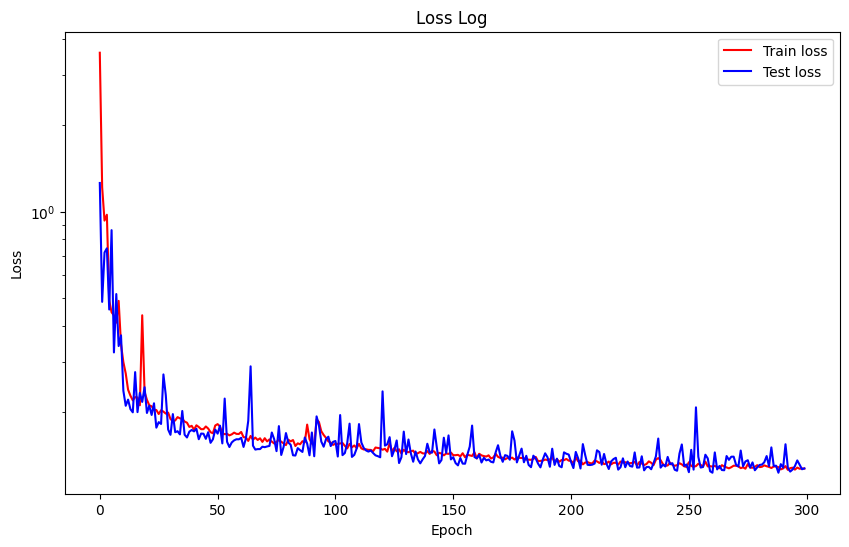

In [15]:
# Plot loss log
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, "r-", label="Train loss")
plt.plot(test_loss_log, "b-", label="Test loss")
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

R2: 0.8722815442824243
MLP_MAE: 0.14091649777668452
Relative L2 norm error for MLP with two hidden layers: 0.3425554613442661
Lower bound is -0.7434579456392205 and upper bound is 0.6795742872851709


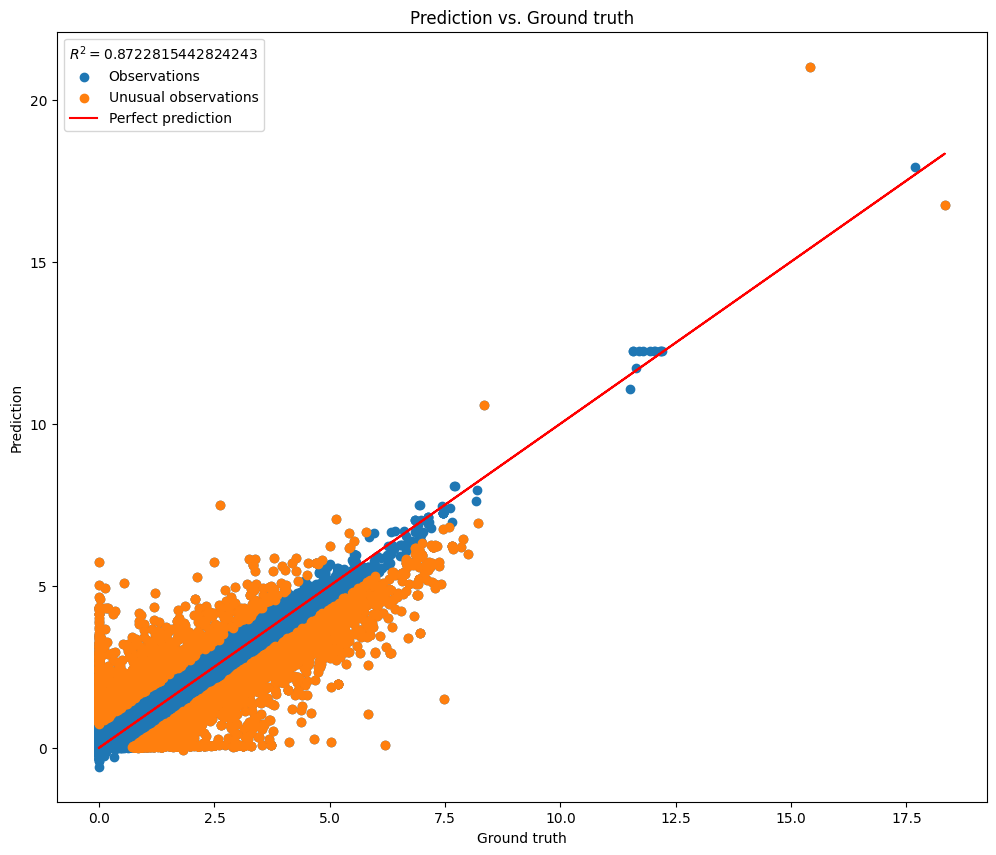

In [16]:
# Make prediction
y_pred = mlpreg_2(x_test_ts)
y_pred = y_pred.data.numpy() # convert to Numpy

# Evaluate model
mlp2_mae_5 = mean_absolute_error(y_test, y_pred)
mlp2_L2_5 = np.linalg.norm(y_test - y_pred, 2)/np.linalg.norm(y_test, 2)
# R2 value
mlp2_r2_5 = r2_score(y_test, y_pred)
print("R2:", mlp2_r2_5)
print("MLP_MAE:", mlp2_mae_5)
print("Relative L2 norm error for MLP with two hidden layers:", mlp2_L2_5)
residuals = y_test - y_pred
lower_bound = residuals.mean() - 2*residuals.std()
upper_bound = residuals.mean() + 2*residuals.std()
print('Lower bound is {} and upper bound is {}'.format(lower_bound, upper_bound))
indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred, label='Observations')
plt.scatter(y_test[indices], y_pred[indices], label='Unusual observations')
plt.plot(y_test, y_test, 'r', label='Perfect prediction')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(title='$R^2={}$'.format(mlp2_r2_5))
plt.title('Prediction vs. Ground truth')
plt.show()

In [ ]:
### Write your code here ###
d = {'model' :['Single One Layer', 'Single Two Layers', 'Minimal One Layer','Minimal Two Layers','Maximal One Layer','Maximal Two Layers','New Maximal One Layers','New Maximal Two Layers'],
'State':['Unoptimised', 'Unoptimised', 'Unoptimised','Unoptimised', 'Unoptimised', 'Unoptimised','Unoptimised','Unoptimised'],
'MAE':[mlp1_mae_1,mlp2_mae_1,mlp1_mae_2,mlp2_mae_2,mlp1_mae_3,mlp2_mae_3,mlp1_mae_5,mlp2_mae_5],
'L2':[mlp1_L2_1,mlp2_L2_1,mlp1_L2_2,mlp2_L2_2,mlp1_L2_3,mlp2_L2_3,mlp1_L2_5,mlp2_L2_5],
'R2':[mlp1_r2_1,mlp2_r2_1,mlp1_r2_2,mlp2_r2_2,mlp1_r2_3,mlp2_r2_3,mlp1_r2_5,mlp2_r2_5]}
d = pd.DataFrame(d)
print(d)

In [20]:
### Write your code here ###
d = {'model' :['Single One Layer', 'Single Two Layers', 'Minimal One Layer','Minimal Two Layers','Maximal One Layer','Maximal Two Layers','New Maximal One Layers','New Maximal Two Layers'],
'State':['Unoptimised', 'Unoptimised', 'Unoptimised','Unoptimised', 'Unoptimised', 'Unoptimised', 'Unoptimised', 'Unoptimised'],
'MAE':[0.157688,0.101059,0.133467,0.098304,0.068094,0.101087,0.1536363,0.14091649],
'L2':[0.386119,0.314238,0.361948,0.321294,0.304419,0.286055,0.3896538,0.34255546],
'R2':[0.837322,0.892253,0.857051,0.887360,0.898881,0.910713,0.834747,0.87228154]}
d = pd.DataFrame(d)
print(d)

                    model        State       MAE        L2        R2
0        Single One Layer  Unoptimised  0.157688  0.386119  0.837322
1       Single Two Layers  Unoptimised  0.101059  0.314238  0.892253
2       Minimal One Layer  Unoptimised  0.133467  0.361948  0.857051
3      Minimal Two Layers  Unoptimised  0.098304  0.321294  0.887360
4       Maximal One Layer  Unoptimised  0.068094  0.304419  0.898881
5      Maximal Two Layers  Unoptimised  0.101087  0.286055  0.910713
6  New Maximal One Layers  Unoptimised  0.153636  0.389654  0.834747
7  New Maximal Two Layers  Unoptimised  0.140916  0.342555  0.872282


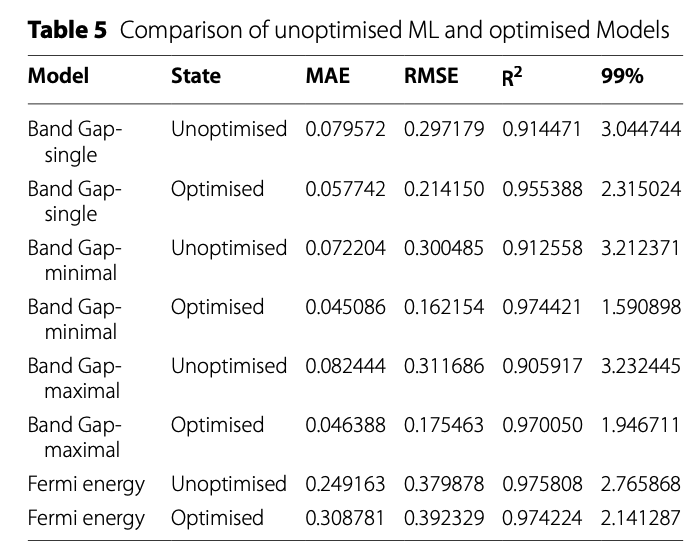

The new maximal dataset gets worse accuracy than maximal dataset before. But the trend of R2 value is the same as the unoptimised MLP model with 2 hidden layers in the paper: minimal dataset has best accuracy, and maximal dataset has the worst accuray. But the results obtained by the new maximal dataset is worse than that obtained in the paper.